In [26]:
import os
import random
import matplotlib.pyplot as plt
from plotting_utils import read_data_from_logs, PLOT_STYLE
import matplotlib.ticker as mtick
from performance_profile import compute_performance_profiles
from score_submissions import compute_leaderboard_score
from tueplots import figsizes, bundles
import seaborn as sns
import numpy as np

In [27]:
SELF_TUING = True
IGNORE_HELD_OUTS = False
QUALIFICATION_SET = False

log_path = "../../submissions_algorithms_v0.5/logs/algoperf_scoring_v05/"
if SELF_TUING:
  log_path = os.path.join(log_path, "self_tuning")
else:
  log_path = os.path.join(log_path, "external_tuning")

full_results = read_data_from_logs(log_path)

Reading data for submission: prize_qualification_baseline
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_init_jax', 'imagenet_resnet_jax']
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_init_jax', 'imagenet_resnet_jax']
['wmt_glu_tanh_jax', 'fastmri_jax', 'criteo1tb_jax', 'librispeech_conformer_layernorm_jax', 'fastmri_tanh_jax', 'ogbg_jax', 'ogbg_model_size_jax', 'imagenet_vit_jax', 'criteo1tb_embed_init_jax', 'librispeech_conformer_jax', 'librispeech_deepspeech_jax', 'wmt_jax', 'imagenet_resnet_large_bn_i

In [28]:
# Remove submission that we did not compute, but reused from the other ruleset:
try:
  del full_results["prize_qualification_baseline_self"]
  del full_results["schedule_free_adamw_self"]
  full_results["schedule_free_adamw"] = full_results.pop("schedule_free_adamw_ext")
except KeyError:
  pass

In [29]:
performance_profile_df = compute_performance_profiles(
    full_results,
    time_col='score',
    min_tau=1.0,
    max_tau=4.0,
    reference_submission_tag=None,
    num_points=100,
    scale='linear',
    verbosity=0,
    self_tuning_ruleset=SELF_TUING,
    strict=False,
    ignore_heldouts=IGNORE_HELD_OUTS,
    use_qualification_set=QUALIFICATION_SET)

scores = compute_leaderboard_score(performance_profile_df)

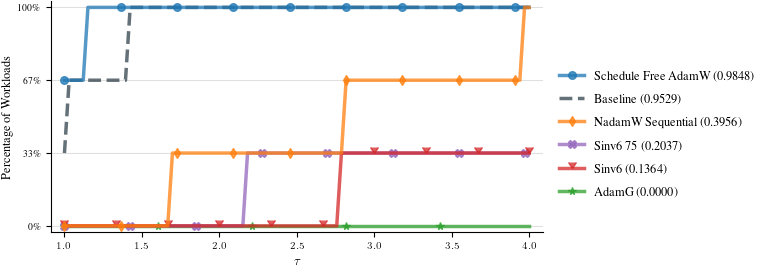

In [30]:
with plt.rc_context(
    {**bundles.iclr2024(), **figsizes.iclr2024(height_to_width_ratio=1)}):
  # Parameters
  random.seed(0)
  x_lims = [1.0, 4.0]
  y_lims = [0, 1]
  ax_lims_push_perc = 0.03
  n_xticks = 7
  n_yticks_major = 4 if QUALIFICATION_SET else 5
  n_yticks_minor = 4 if QUALIFICATION_SET else 9

  fig, ax = plt.subplots()

  for row in performance_profile_df.iterrows():
    submission = row[0]
    performance_profile_series = row[1:][0]
    x = performance_profile_series.index.to_numpy()
    y = performance_profile_series.to_numpy()

    n_markers = 7 + random.randint(-2, 2)
    markevery = int(len(x) / n_markers)

    ax.plot(
        x,
        y,
        color=PLOT_STYLE[submission]["color"],
        label=PLOT_STYLE[submission]["label"] +
        f" ({scores.loc[submission, 'score']:.4f})",
        linestyle=PLOT_STYLE[submission]["linestyle"],
        linewidth=2.5,
        alpha=0.75,
        marker=PLOT_STYLE[submission]["marker"],
        markersize=5.5,
        markevery=markevery,
    )

  # Style
  ax_lims_push = [
      ax_lims_push_perc * (x_lims[1] - x_lims[0]),
      ax_lims_push_perc * (y_lims[1] - y_lims[0]),
  ]
  ax.set_xticks(np.linspace(x_lims[0], x_lims[1], n_xticks))
  ax.set_yticks(np.linspace(y_lims[0], y_lims[1], n_yticks_major))
  ax.set_yticks(np.linspace(y_lims[0], y_lims[1], n_yticks_minor), minor=True)
  ax.set_xlim(
      left=x_lims[0] - ax_lims_push[0], right=x_lims[1] + ax_lims_push[0])
  ax.set_ylim(
      bottom=y_lims[0] - ax_lims_push[1], top=y_lims[1] + ax_lims_push[1])
  ax.set_xlabel(r"$\tau$")
  ax.set_ylabel("Percentage of Workloads")
  ax.yaxis.set_major_formatter(
      mtick.PercentFormatter(xmax=1.0, symbol='\%', is_latex=True))
  ax.grid(axis="y", which="both", linewidth=0.75)
  ax.grid(axis="x", which="both", linewidth=0.0)
  sns.despine(ax=ax)

  # Get handles and labels
  handles, labels = ax.get_legend_handles_labels()
  # Sort by label
  labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0][-5:], reverse=True))

  # Create the legend
  fig.legend(
      handles,
      labels,
      frameon=False,
      loc='center right',
      bbox_to_anchor=(1.4, 0.5),
      labelspacing=0.95,
      fontsize=9,
  )
  filename = "plots/performance_profile"
  filename += "_self_tuning" if SELF_TUING else "_external_tuning"
  filename += "_ignore_heldouts" if IGNORE_HELD_OUTS else ""
  filename += "_qualification_set" if QUALIFICATION_SET else ""
  
  plt.savefig(f"{filename}.pdf")
  plt.show()